# Linear Regression, Part 2

In this chapter we will start with a quick walkthrough of the mathematics behind this well-known problem, before moving on to see how linear models can be generalized to account for more complicated patterns in data.

We begin with the standard imports:

In [1]:
%matplotlib inline

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form:

$$
y = ax + b
$$

where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

Consider the following data, which is scattered about a line with a slope of 2 and an intercept of –5 (see the following figure):

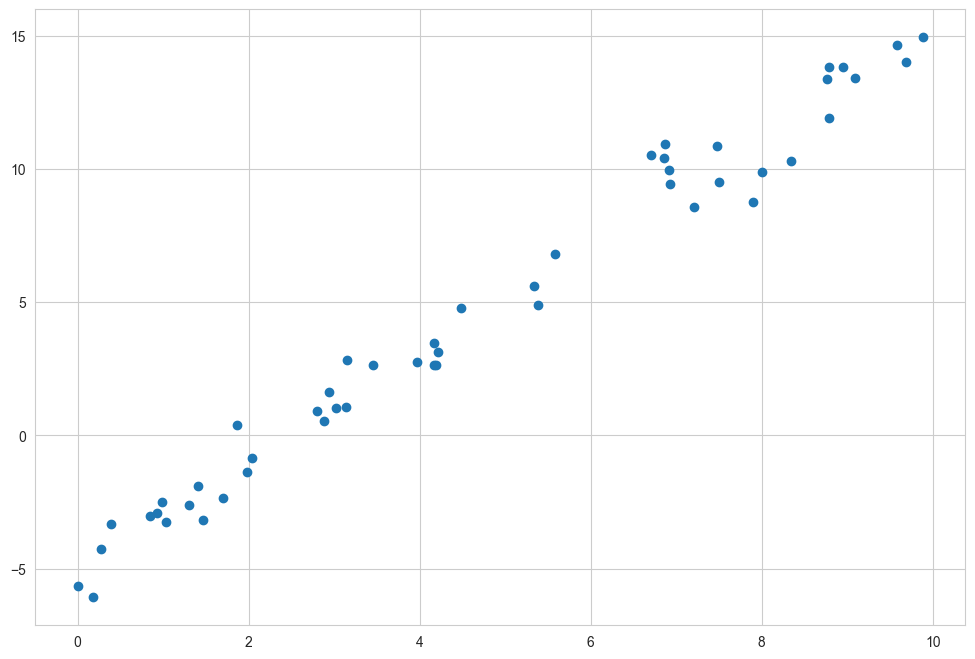

In [4]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

We can use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line, as shown in the following figure:

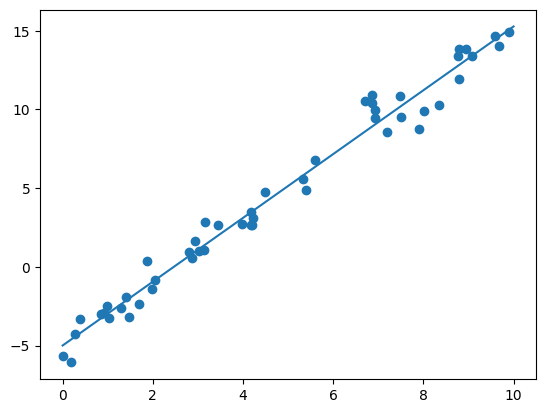

In [5]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are `coef_` and `intercept_`:

In [6]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.0272088103606944
Model intercept: -4.9985770855532


We see that the results are very close to the values used to generate the data, as we might hope.

The `LinearRegression` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
where there are multiple $x$ values.
Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyperplane to points in higher dimensions.

The multidimensional nature of such regressions makes them more difficult to visualize, but we can see one of these fits in action by building some example data, using NumPy's matrix multiplication operator:

In [7]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5000000000000033
[ 1.5 -2.   1. ]


Here the $y$ data is constructed from a linear combination of three random $x$ values, and the linear regression recovers the coefficients used to construct the data.

In this way, we can use the single `LinearRegression` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Polynomial Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
We have seen one version of this before, in the `PolynomialRegression` pipeline used in [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) and [Feature Engineering](05.04-Feature-Engineering.ipynb).
The idea is to take our multidimensional linear model:

$$
y = a_0 + a_1 x_1 + a_2 x_2 + a_3 x_3 + \cdots
$$

and build the $x_1, x_2, x_3,$ and so on from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:

$$
y = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots
$$

Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $a_n$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial Basis Functions

This polynomial projection is useful enough that it is built into Scikit-Learn, using the `PolynomialFeatures` transformer:

In [14]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array, where each column contains the exponentiated value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

As we saw in [Feature Engineering](05.04-Feature-Engineering.ipynb), the cleanest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [12]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With this transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise (see the following figure):

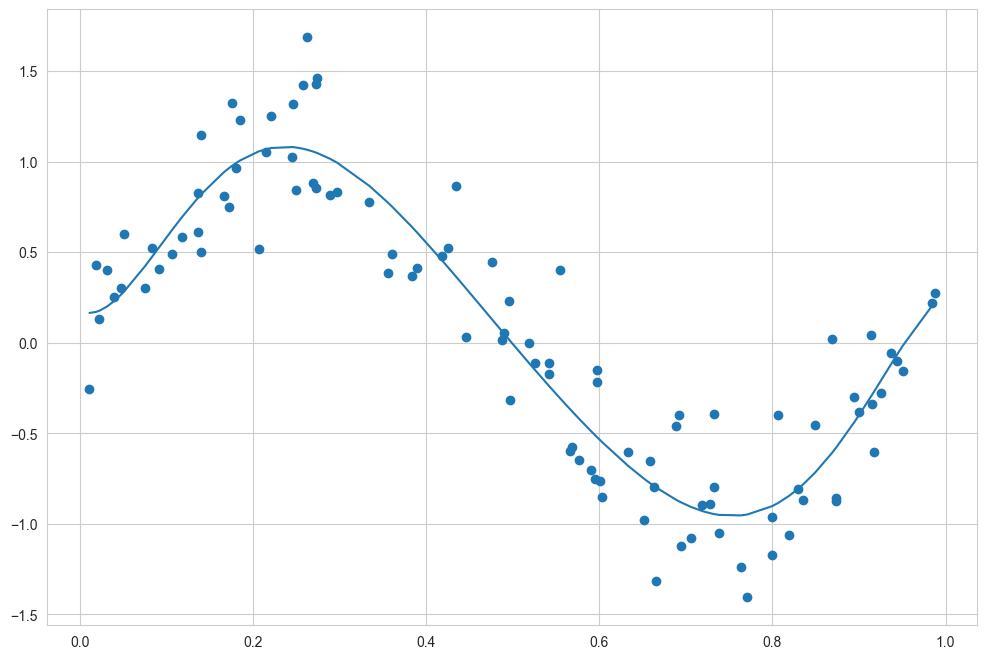

In [17]:
# rng = np.random.RandomState(1)
# x = 10 * rng.rand(50)
# y = np.sin(x) + 0.1 * rng.randn(50)

n_samples = 100
x = np.sort(np.random.uniform(0, 1, n_samples))
y = np.sin(2 * np.pi * x) + 0.3 * np.random.randn(n_samples)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(x[:, np.newaxis])

plt.scatter(x, y)
plt.plot(x, yfit)

Our linear model, through the use of seventh-order polynomial basis functions, can provide an excellent fit to this nonlinear data!

## Regularization

The introduction of basis functions into our linear regression makes the model much more flexible, but it also can very quickly lead to overfitting (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).


The lower panel of this figure shows the amplitude of the basis function at each location.
This is typical overfitting behavior when basis functions overlap: the coefficients of adjacent basis functions blow up and cancel each other out.
We know that such behavior is problematic, and it would be nice if we could limit such spikes explicitly in the model by penalizing large values of the model parameters.
Such a penalty is known as *regularization*, and comes in several forms.

### Ridge Regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as *ridge regression* or $L_2$ *regularization* (sometimes also called *Tikhonov regularization*).
This proceeds by penalizing the sum of squares (2-norms) of the model coefficients $\theta_n$. In this case, the penalty on the model fit would be: 

$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

where $\alpha$ is a free parameter that controls the strength of the penalty.
This type of penalized model is built into Scikit-Learn with the `Ridge` estimator (see the following figure):

The $\alpha$ parameter is essentially a knob controlling the complexity of the resulting model.
In the limit $\alpha \to 0$, we recover the standard linear regression result; in the limit $\alpha \to \infty$, all model responses will be suppressed.
One advantage of ridge regression in particular is that it can be computed very efficiently—at hardly more computational cost than the original linear regression model.

**Generate Synthetic Data**

Let's create some synthetic data that follows a non-linear pattern with some noise:

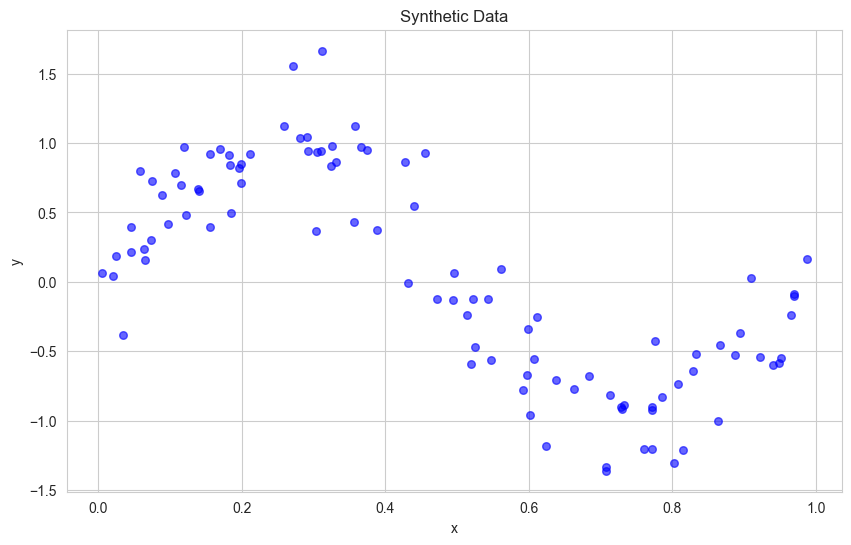

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_samples = 100
X = np.sort(np.random.uniform(0, 1, n_samples))
y = np.sin(2 * np.pi * X) + 0.3 * np.random.randn(n_samples)

# X = 10 * rng.rand(n_samples)
# y = np.sin(X) + 0.1 * rng.randn(n_samples)

# Create a dataframe
data = pd.DataFrame({
    'x': X,
    'y': y
})

# Generate polynomial features
for i in range(2, 16):
    data['x_%d' % i] = data['x'] ** i

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(data['x'], data['y'], color='blue', s=30, alpha=0.6)
plt.title('Synthetic Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Understanding Overfitting

Let's implement functions to fit both standard linear regression and Ridge regression with polynomial features:

In [19]:
def linear_regression(data, power, models_to_plot):
    # Initialize predictors
    predictors = ['x']
    if power >= 2:
        predictors.extend(['x_%d' % i for i in range(2, power+1)])
    
    # Fit the model
    linreg = LinearRegression()
    linreg.fit(data[predictors], data['y'])
    y_pred = linreg.predict(data[predictors])
    
    # Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'], y_pred, 'r-', linewidth=2)
        plt.plot(data['x'], data['y'], 'b.', alpha=0.6)
        plt.title('Linear Regression with Polynomial Degree: %d' % power)
    
    # Return the result in pre-defined format
    rss = sum((y_pred - data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    
    # Pad with zeros to match the number of columns in the DataFrame
    # We need 17 values total: 'rss', 'intercept', and 15 coefficients
    while len(ret) < 17:
        ret.append(0)
    
    return ret[:17]  # Ensure we return exactly the right number of values

def ridge_regression(data, power, alpha, models_to_plot):
    # Initialize predictors
    predictors = ['x']
    if power >= 2:
        predictors.extend(['x_%d' % i for i in range(2, power+1)])
    
    # Fit the model
    ridgereg = Ridge(alpha=alpha)
    ridgereg.fit(data[predictors], data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    # Check if a plot is to be made for the entered power
    if power in models_to_plot:
        # Use subplot position as a single integer (e.g., 1, 2, 3, 4, 5)
        # and convert it to the correct format for plt.subplot
        subplot_pos = models_to_plot[power]
        plt.subplot(2, 3, subplot_pos)  # 2 rows, 3 columns, position subplot_pos
        
        plt.plot(data['x'], y_pred, 'r-', linewidth=2)
        plt.plot(data['x'], data['y'], 'b.', alpha=0.6)
        plt.title(f'Ridge Regression with Polynomial Degree: {power}, Alpha: {alpha:.2f}')
    
    # Return the result in pre-defined format
    rss = sum((y_pred - data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    
    # Pad with zeros to match the number of columns in the DataFrame
    while len(ret) < power + 2:  # rss, intercept, and power coefficients
        ret.append(0)
    
    return ret[:power + 2]  # Ensure we return exactly the right number of values

### Comparing Linear Regression with Different Polynomial Degrees

Let's visualize how standard linear regression behaves with increasing polynomial degrees:

Number of columns in DataFrame: 17


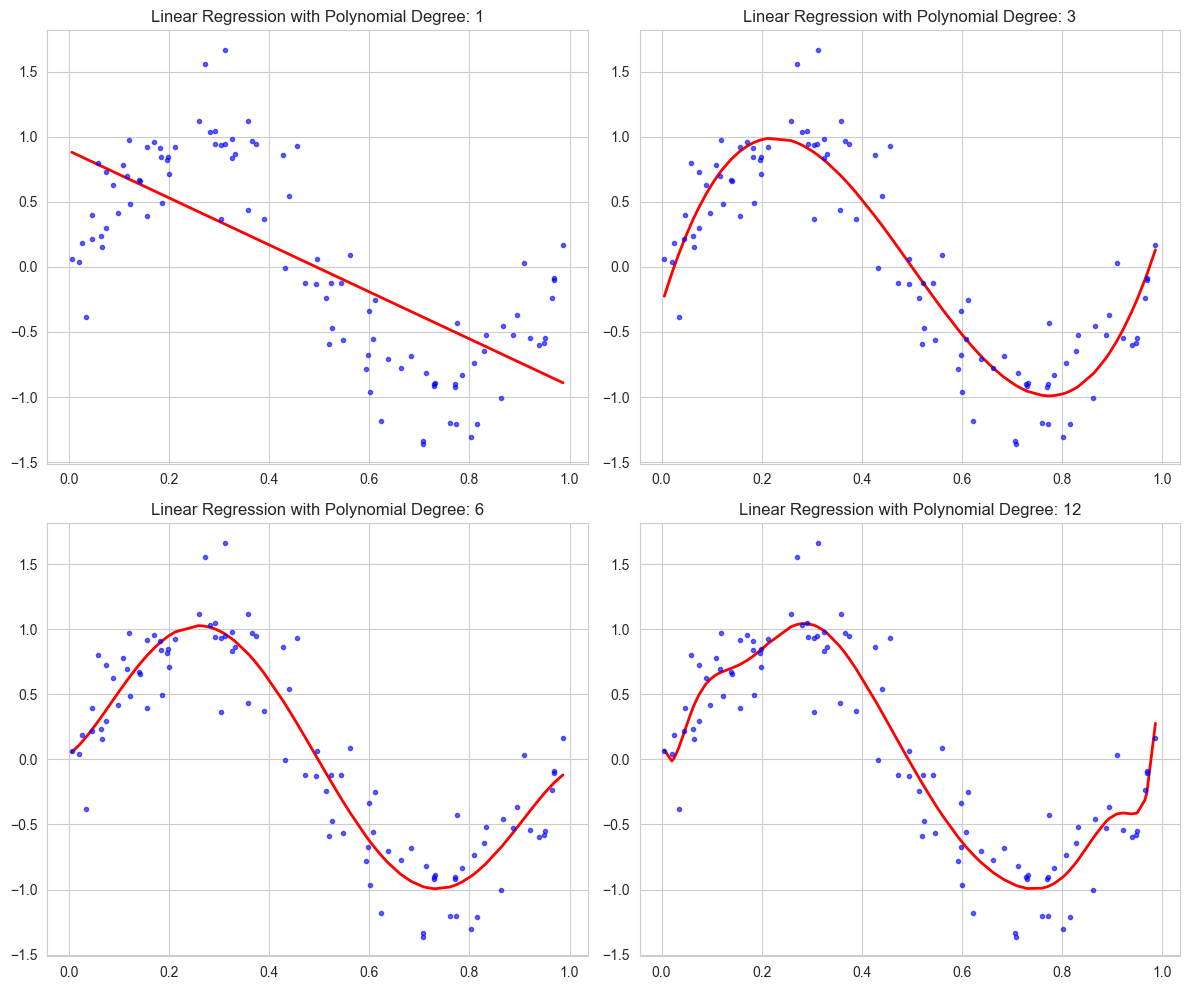

In [20]:
# Initialize a dataframe to store the results
# This should have 17 columns: 'rss', 'intercept', and 15 coefficient columns
linear_model = pd.DataFrame(columns=['rss', 'intercept'] + ['coef_x_%d' % i for i in range(1, 16)])

# Print the number of columns to verify
print(f"Number of columns in DataFrame: {len(linear_model.columns)}")

# Set the powers for which we want to plot the models
models_to_plot = {1: 221, 3: 222, 6: 223, 12: 224}

# Fit linear regression models with different powers
plt.figure(figsize=(12, 10))
for power in range(1, 16):
    linear_model.loc[power] = linear_regression(data, power, models_to_plot)

plt.tight_layout()
plt.show()


Ridge regression adds a penalty term to the cost function, which is the sum of the squared coefficients multiplied by a regularization parameter alpha. This helps prevent overfitting by keeping the coefficients small.

The cost function for Ridge regression is:

$$J(\theta) = MSE + \alpha \sum_{i=1}^{n} \theta_i^2$$

Where:
- MSE is the mean squared error
- α (alpha) is the regularization parameter
- θᵢ are the model coefficients (excluding the intercept)

Let's compare Ridge regression with different alpha values for a high-degree polynomial:

c:\Programs\Anaconda3\envs\pth\lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.187e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


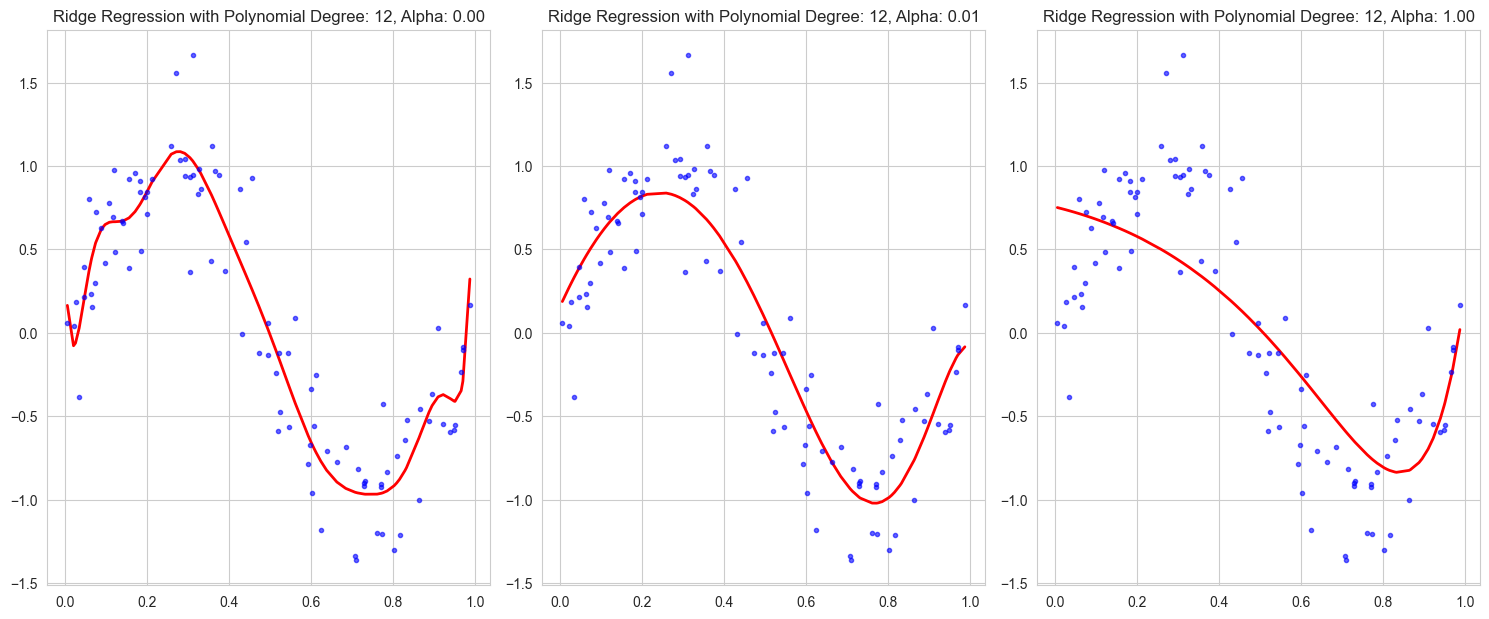

In [21]:
# Initialize a dataframe to store the results
ridge_models = {}
alphas = [0,  0.01, 1]
power = 12  # Using a high polynomial degree to demonstrate overfitting

plt.figure(figsize=(15, 12))
counter = 1

for alpha in alphas:
    ridge_models[alpha] = pd.DataFrame(columns=['rss', 'intercept'] + ['coef_x_%d' % i for i in range(1, power+1)])
    # Pass the counter as the subplot position (1, 2, 3, 4, 5)
    ridge_models[alpha].loc[power] = ridge_regression(data, power, alpha, {power: counter})
    counter += 1

plt.tight_layout()
plt.show()

### Visualizing the Effect of Alpha on Coefficients

Let's see how the coefficients change with different alpha values:

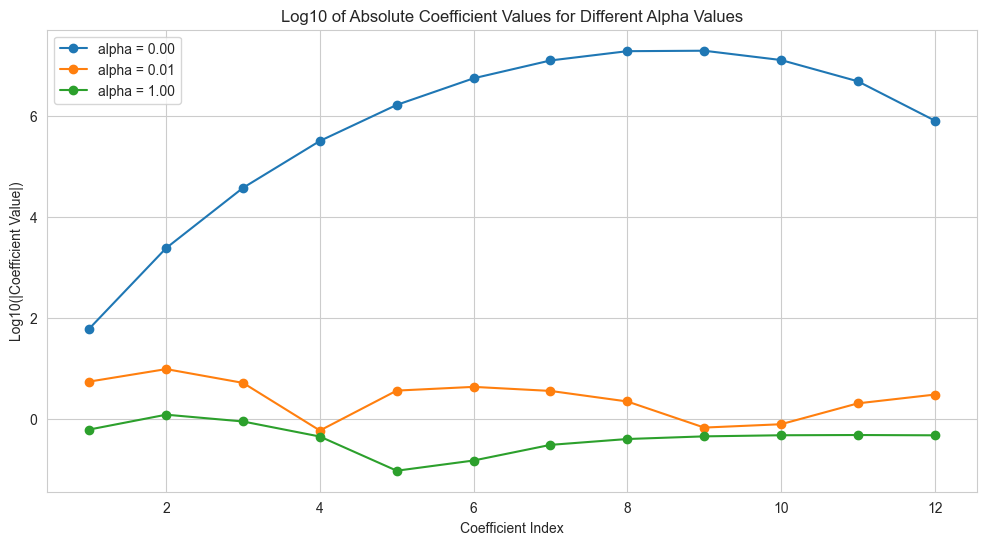

In [22]:
# Extract the coefficients for different alpha values
coef_matrix = pd.DataFrame(index=range(1, power+1))

for alpha in alphas:
    # Take the absolute value and then log transform the coefficients
    coef_matrix['alpha = %.2f' % alpha] = np.log10(np.abs(ridge_models[alpha].loc[power][2:]) + 1e-10)

# Plot the log-transformed coefficient values
plt.figure(figsize=(12, 6))
for alpha in alphas:
    # Plot log10 of absolute coefficient values
    plt.plot(range(1, power+1), np.log10(np.abs(ridge_models[alpha].loc[power][2:]) + 1e-10), 
             'o-', label='alpha = %.2f' % alpha)

plt.title('Log10 of Absolute Coefficient Values for Different Alpha Values')
plt.xlabel('Coefficient Index')
plt.ylabel('Log10(|Coefficient Value|)')
plt.legend()
plt.grid(True)
plt.show()

### Lasso Regression ($L_1$ Regularization)

Another common type of regularization is known as *lasso regression* or *L~1~ regularization* involves penalizing the sum of absolute values (1-norms) of regression coefficients:

$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

Though this is conceptually very similar to ridge regression, the results can differ surprisingly. For example, due to its construction, lasso regression tends to favor *sparse models* where possible: that is, it preferentially sets many model coefficients to exactly zero.

<!-- We can see this behavior if we duplicate the previous example using L1-normalized coefficients (see the following figure): -->

With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions.
As with ridge regularization, the $\alpha$ parameter tunes the strength of the penalty and should be determined via, for example, cross-validation (refer back to [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb) for a discussion of this).

# Sparse Optimization: Theory and Applications (Further Reading)
Sparse optimization is a fundamental paradigm in mathematical modeling that seeks solutions with few non-zero elements, often formalized through ℓ₁-norm regularization or non-convex penalties. This framework is grounded in the **Compressed Sensing (CS)** theory {cite}`Donoho2006CS`, which guarantees exact signal recovery from sub-Nyquist measurements if the signal is sparse in some basis. Key applications include:  

1. **Medical Imaging**: CS enables faster MRI scans by reconstructing images from limited k-space samples (Lustig et al., 2007), as highlighted in the [CUHK lecture notes on CS](http://dsp.ee.cuhk.edu.hk/eleg5481/Lecture%20notes/13-%20compressive%20sensing/cs.pdf) (p. 13).  
2. **Signal Processing**: Sparse methods underpin denoising (e.g., wavelet shrinkage) and inpainting, where total variation minimization preserves edges while removing noise (Figueiredo, 2021, [slides p. 8](https://indico.math.cnrs.fr/event/6637/contributions/5334/attachments/3055/3951/Figueiredo_CIMI-ANITI_Toulouse_2021.pdf)).  
3. **Machine Learning**: Sparse regression (e.g., LASSO; Tibshirani, 1996) and robust PCA (Candès et al., 2011) are critical for feature selection and anomaly detection. The [Ghent tutorial](https://telin.ugent.be/~sanja/Presentation/Tutorial_IMREC_Part1.pdf) (p. 5) further links sparsity to deep network pruning.  
4. **Statistics**: High-dimensional inference (e.g., genomics) benefits from sparsity-induced interpretability (Bühlmann & Van de Geer, 2011).  

The field continues to evolve with **non-convex penalties** (e.g., SCAD) and **greedy algorithms** (OMP), balancing computational efficiency and statistical guarantees. For a unified perspective, see the cited references and tutorials.  

---


## Connection Between Sparse Learning and Functional Analysis

Sparse recovery techniques like **OMP** and **LASSO** are deeply rooted in **functional analysis**, which explains why terms like **Hilbert spaces** and **Banach spaces** frequently appear in machine learning research. These mathematical frameworks provide the theoretical foundation for understanding sparsity-inducing methods.

### Hilbert Spaces and Orthogonal Projections
Hilbert spaces (complete inner product spaces) are essential for analyzing **orthogonal projections** and **basis expansions**. For example:  
- **OMP** iteratively projects the residual onto the span of selected basis vectors, leveraging the **orthogonality principle** to minimize error at each step.  
- The **inner product structure** of Hilbert spaces enables efficient computation of correlations between residuals and dictionary atoms (columns of $ X $).

### Banach Spaces and $ \ell_1 $-Regularization
**LASSO** operates in the context of Banach spaces (complete normed vector spaces) due to its reliance on the $ \ell_1 $-norm:  
- The $ \ell_1 $-norm’s **non-smoothness** at the origin induces sparsity, a property studied in Banach space geometry.  
- Unlike Hilbert spaces, Banach spaces generalize optimization techniques to **non-Euclidean settings**, crucial for sparse regularization.

### Fourier, Wavelet, and Other Representations 
Sparse learning often exploits **transform domains** (e.g., Fourier, wavelet, or learned dictionaries) where signals admit **concise representations**: - These domains provide **structured bases** where only a few coefficients are significant. - The **connection to functional analysis** arises because such bases typically form **frames** or **Riesz bases** in Hilbert spaces, ensuring stable sparse approximations.

## From Fixed Bases to Learned Representations
1. **Classical Sparse Coding**:  
   - Relies on **predefined bases** (e.g., Fourier, wavelets) where signals admit sparse representations.  
   - These bases often form **frames** or **Riesz bases** in Hilbert spaces, ensuring stable approximations.  

2. **Convolutional Neural Networks (CNNs)**:  
   - Learn **adaptive bases/filters** from data, implicitly constructing sparse-like representations through:  
     - **Local connectivity**: Filters act as localized basis functions.  
     - **Activation sparsity**: ReLU promotes de facto sparsity in feature maps.  
   - While CNNs lack explicit $ \ell_0 $/$ \ell_1 $ constraints, their hierarchical structure approximates **multi-scale sparse decompositions**, akin to wavelet analysis but data-driven.  

### The Evolving Role of Sparse Methods
While deep learning has reduced reliance on *handcrafted* sparse models in some domains, sparse methods remain relevant because:  

1. **Interpretability**:  
   - OMP/LASSO yield **explicit basis selections**, whereas CNNs operate as black boxes.  
   - Critical in fields like medicine or physics where model transparency is required.  

2. **Data-Efficiency**:  
   - Sparse methods often outperform DL in **low-data regimes** (e.g., medical imaging with small datasets).  

3. **Theoretical Guarantees**:  
   - Compressed sensing (**OMP**) and convex optimization (**LASSO**) provide **recovery guarantees** under precise conditions, unlike empirical DL results.  

4. **Hybrid Approaches**:  
   - Modern architectures (e.g., **ISTA-Net**, **Learned Iterative Shrinkage**) blend sparse priors with deep learning, showing that sparsity remains a useful *inductive bias*.  

 
Sparse learning and deep learning are complementary:  
- **CNNs** dominate when data is abundant and interpretability is secondary.  
- **OMP/LASSO** persist in scenarios requiring rigor, efficiency, or transparency.  
- **Functional analysis** bridges these paradigms, providing tools to analyze both fixed and learned representations.  




---

## MRI reconstruction

MRI reconstruction can be formulated as an inverse problem where the goal is to recover the original image $ \mathbf{m} $ from under-sampled k-space measurements $ \mathbf{y} $. This is achieved using sparse optimization techniques.

A common formulation for MRI reconstruction is:

$$
\min_{\mathbf{m}} \|\mathbf{F}_u \mathbf{m} - \mathbf{y}\|_2^2 + \lambda \|\Psi \mathbf{m}\|_p
$$

where:
- $ \mathbf{m} $ represents the MRI image to be reconstructed.
- $ \mathbf{F}_u $ is the **under-sampled Fourier operator**, mapping the image to k-space.
- $ \mathbf{y} $ is the **acquired k-space data** (limited measurements).
- $ \Psi $ is the **sparsifying transform** (e.g., wavelet or total variation).
- $ \|\Psi \mathbf{m}\|_p $ represents the **sparsity constraint**, often chosen as $ \ell_1 $ (similar to LASSO) or $ \ell_0 $ (similar to OMP).
- $ \lambda $ controls the balance between data fidelity and sparsity enforcement.

By leveraging sparsity, MRI reconstruction enables faster scans with fewer measurements while preserving essential anatomical details.


## PyTomography

**PyTomography** is an open-source Python library designed for **medical image reconstruction**, particularly in **SPECT (Single-Photon Emission Computed Tomography)** and **PET (Positron Emission Tomography)** imaging. Developed to address the challenges of **quantitative tomographic reconstruction**, PyTomography provides a **flexible, modular framework** for implementing advanced reconstruction algorithms, including **attenuation correction, scatter correction, and resolution modeling**.  

### **Key Features**  
✅ **Open-source & community-driven** ([GitHub](https://github.com/PyTomography/PyTomography))  
✅ **Supports multiple reconstruction techniques** (OSEM, MLEM, deep learning-based methods)  
✅ **Integrates with GPU acceleration** for faster computations  
✅ **Well-documented** with tutorials and API references ([ReadTheDocs](https://pytomography.readthedocs.io/en/latest/))  
✅ **Validated in peer-reviewed research** ([Scientific Reports, 2024](https://www.sciencedirect.com/science/article/pii/S235271102400390X))  

### **Why Use PyTomography?**  
PyTomography bridges the gap between **research and clinical applications** by offering:  
- **Reproducible** reconstruction workflows  
- **Customizable** forward and backward projection models  
- **Seamless integration** with Python’s scientific computing stack (NumPy, PyTorch)  

Whether for **academic research, algorithm development, or clinical prototyping**, PyTomography provides a **powerful, accessible toolkit** for next-generation medical imaging reconstruction. 

## PySAP

The **Python Sparse data Analysis Package (PySAP)** was developed as part of COSMIC, a multi-disciplinary collaboration between **NeuroSpin**, experts in biomedical imaging, and **CosmoStat**, experts in astrophysical image processing. PySAP is designed to provide state-of-the-art signal processing tools for various imaging domains, including:

- **Astronomy**
- **Electron Tomography**
- **Magnetic Resonance Imaging (MRI)**

One of PySAP’s core contributions lies in **sparse optimization**, a powerful technique widely used for reconstructing images from incomplete or noisy data. The package implements advanced **compressed sensing algorithms**{cite}`theodoridis2020machine`, allowing efficient image restoration while preserving essential features.

In medical imaging, PySAP plays a crucial role in MRI reconstruction by leveraging **sparsity-based approaches** to improve scan efficiency. It enables:

- Reduced scanning time while maintaining image quality
- Improved reconstruction of under-sampled k-space data
- Integration of machine learning techniques for further enhancement

The first release of PySAP was presented in Farrens et al. {cite}`gueddari2020PySAP` and continues to evolve as a robust tool for sparse signal processing.

For further exploration, visit the [PySAP GitHub repository](https://github.com/CEA-COSMIC/pysap).

In [deep learning course](http://fum-cs.github.io/dl), we will encounter additional examples of minimizing $ ||Ax - b|| $, including applications like image deblurring and super-resolution.


![](img/Rank-Based-Methods.jpg)

For valuable references on Ridge and Shrinkage methods, consider consulting Prof. Arashi's books {cite}`saleh2019theory,saleh2022rank`.

---


# Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.
We already saw this data in [Working With Time Series](03.11-Working-with-Time-Series.ipynb), but here we will join the bike data with another dataset and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.
Fortunately, the National Oceanic and Atmospheric Administration (NOAA) makes its daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) available—I used station ID USW00024233—and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.
As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

In [14]:
# url = 'https://raw.githubusercontent.com/jakevdp/bicycle-data/main'
# !curl -O {url}/FremontBridge.csv
# !curl -O {url}/SeattleWeather.csv

In [15]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv',
                     index_col='Date', parse_dates=True)
weather = pd.read_csv('SeattleWeather.csv',
                      index_col='DATE', parse_dates=True)

For simplicity, let's look at data prior to 2020 in order to avoid the effects of the COVID-19 pandemic, which significantly affected commuting patterns in Seattle:

In [16]:
counts = counts[counts.index < "2020-01-01"]
weather = weather[weather.index < "2020-01-01"]

Next we will compute the total daily bicycle traffic, and put this in its own `DataFrame`:

In [17]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

We saw previously that the patterns of use generally vary from day to day. Let's account for this in our data by adding binary columns that indicate the day of the week:

In [18]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2020')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also might suspect that the hours of daylight would affect how many people ride. Let's use the standard astronomical calculation to add this information (see the following figure):

(8.0, 17.0)

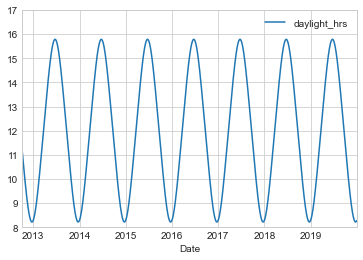

In [20]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the average temperature and total precipitation to the data.
In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [21]:
weather['Temp (F)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])
weather['Rainfall (in)'] = weather['PRCP']
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['Rainfall (in)', 'Temp (F)', 'dry day']])

Finally, let's add a counter that increases from day 1, and measures how many years have passed.
This will let us measure any observed annual increase or decrease in daily crossings:

In [22]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

Now our data is in order, and we can take a look at it:

In [23]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Rainfall (in),Temp (F),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,14084.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,56.0,1,0.000000
2012-10-04,13900.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,56.5,1,0.002740
2012-10-05,12592.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,59.5,1,0.005479
2012-10-06,8024.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,60.5,1,0.008219
2012-10-07,8568.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,60.5,1,0.010959


With this in place, we can choose the columns to use, and fit a linear regression model to our data.
We will set `fit_intercept=False`, because the daily flags essentially operate as their own day-specific intercepts:

In [24]:
# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
                'holiday', 'daylight_hrs', 'Rainfall (in)',
                'dry day', 'Temp (F)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually (see the following figure):

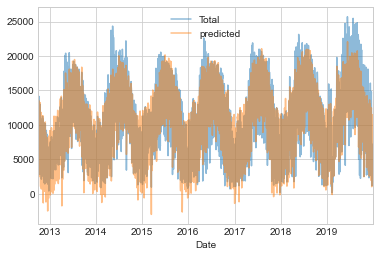

In [25]:
daily[['Total', 'predicted']].plot(alpha=0.5);

From the fact that the data and model predictions don't line up exactly, it is evident that we have missed some key features.
Either our features are not complete (i.e., people decide whether to ride to work based on more than just these features), or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures).
Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [26]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              -3309.953439
Tue              -2860.625060
Wed              -2962.889892
Thu              -3480.656444
Fri              -4836.064503
Sat             -10436.802843
Sun             -10795.195718
holiday          -5006.995232
daylight_hrs       409.146368
Rainfall (in)    -2789.860745
dry day           2111.069565
Temp (F)           179.026296
annual             324.437749
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty.
We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [27]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [28]:
print(pd.DataFrame({'effect': params.round(0),
                    'uncertainty': err.round(0)}))

                effect  uncertainty
Mon            -3310.0        265.0
Tue            -2861.0        274.0
Wed            -2963.0        268.0
Thu            -3481.0        268.0
Fri            -4836.0        261.0
Sat           -10437.0        259.0
Sun           -10795.0        267.0
holiday        -5007.0        401.0
daylight_hrs     409.0         26.0
Rainfall (in)  -2790.0        186.0
dry day         2111.0        101.0
Temp (F)         179.0          7.0
annual           324.0         22.0


The `effect` column here, roughly speaking, shows how the number of riders is affected by a change of the feature in question.
For example, there is a clear divide when it comes to the day of the week: there are thousands fewer riders on weekends than on weekdays.
We also see that for each additional hour of daylight, 409 ± 26 more people choose to ride; a temperature increase of one degree Fahrenheit encourages 179 ± 7 people to grab their bicycle; a dry day means an average of 2,111 ± 101 more riders,
and every inch of rainfall leads 2,790 ± 186 riders to choose another mode of transport.
Once all these effects are accounted for, we see a modest increase of 324 ± 22 new daily riders each year.

Our simple model is almost certainly missing some relevant information. For example, as mentioned earlier, nonlinear effects (such as effects of precipitation *and* cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in a simple linear model.
Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).
These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

# Perceptron
* Represents a single neuron (node) with inputs $x_i$, a bias $w_0$, and output $y$
* Each connection has a (synaptic) weight $w_i$. The node outputs $\hat{y} = \sum_{i}^n x_{i}w_i + w_0$
* The _activation function_ predicts 1 if $\mathbf{xw} + w_0 > 0$, -1 otherwise
* Weights can be learned with (stochastic) gradient descent and Hinge(0) loss
    * Updated _only_ on misclassification, corrects output by $\pm1$
    
    $$\mathcal{L}_{Perceptron} = max(0,-y_i (\mathbf{w}\mathbf{x_i} + w_0))$$
    
    $$\frac{\partial \mathcal{L_{Perceptron}}}{\partial w_i} =  \begin{cases}-y_i x_i & y_i (\mathbf{w}\mathbf{x_i} + w_0) < 0\\ 0 & \text{otherwise} \\ \end{cases}$$
    
![](img/perceptron.png)

# Logistic regression
* Aims to predict the _probability_ that a point belongs to the positive class
* Converts target values {negative (blue), positive (red)} to {0,1}
* Fits a _logistic_ (or _sigmoid_ or _S_ curve) function through these points
    * Maps (-Inf,Inf) to a probability [0,1]
    
    $$ \hat{y} = \textrm{logistic}(f_{\theta}(\mathbf{x})) = \frac{1}{1+e^{-f_{\theta}(\mathbf{x})}} $$
    
* E.g. in 1D: $ \textrm{logistic}(x_1w_1+w_0) = \frac{1}{1+e^{-x_1w_1-w_0}} $